# Analysis part

In [2]:
library(ggplot2)
library(quantreg)


df = read.csv('merged_datasets_final/merged_Charizard___Holo_2016_Evolutions.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock to returns
df$adjclosestock_return <- c(NA, diff(log(df$adjclosestock)))

#remove rows with NA in the newly created return columns
df <- na.omit(df)

head(df)

,date,grade7price,grade8price,grade9price,grade10price,adjclosestock,volume,adjclosebond,stockreturns,bondadjusted,excessreturns,grade7price_return,grade8price_return,grade9price_return,grade10price_return,adjclosestock_return
2,2017-01-01,22,14.00000,50.44444,380.0000,2278.87,70576420000,3.051,0.0178843582,0.03051,0.02180204,0,0.00000000,-0.13900989,0.003523745,0.0177263146
3,2017-02-01,22,14.00000,29.90000,390.7117,2363.64,69260940000,2.968,0.0371981601,0.02968,0.06440241,0,0.00000000,-0.52301414,0.027798610,0.0365230007
4,2017-03-01,22,9.59000,20.79333,390.7117,2362.72,81664010000,3.018,-0.0003891971,0.03018,-0.01723554,0,-0.37833644,-0.36322606,0.000000000,-0.0003892729
5,2017-04-01,22,13.48333,24.52571,308.6100,2384.20,65369860000,2.952,0.0090912087,0.02952,0.03095999,0,0.34073347,0.16508971,-0.235891519,0.0090501325
6,2017-05-01,22,13.14400,26.52500,308.6100,2411.80,79719460000,2.857,0.0115762512,0.02857,0.04375775,0,-0.02548897,0.07836555,0.000000000,0.0115097591
7,2017-06-01,22,16.24625,26.23200,250.2980,2423.41,81078810000,2.840,0.0048137752,0.02840,0.01076414,0,0.21189673,-0.01110764,-0.209426136,0.0048022260


## Visualisation

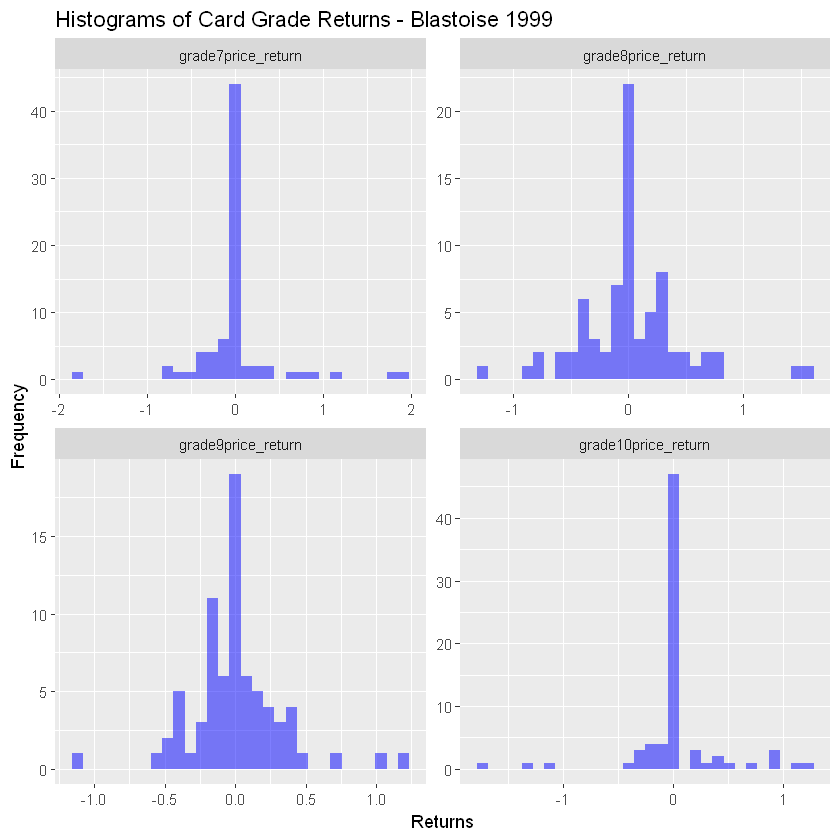

In [3]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

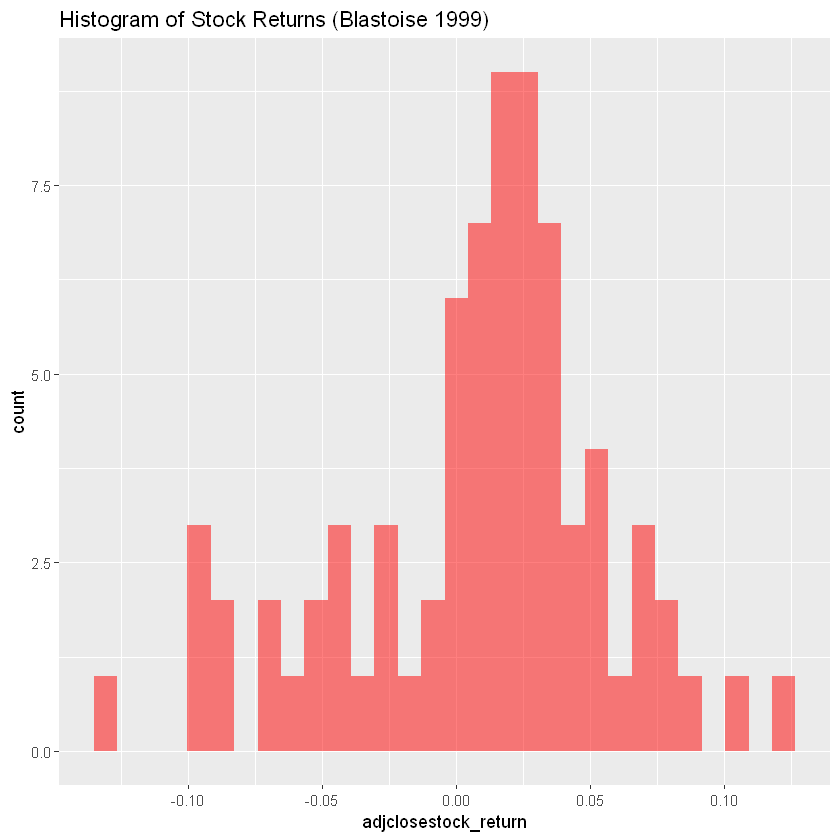

In [4]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

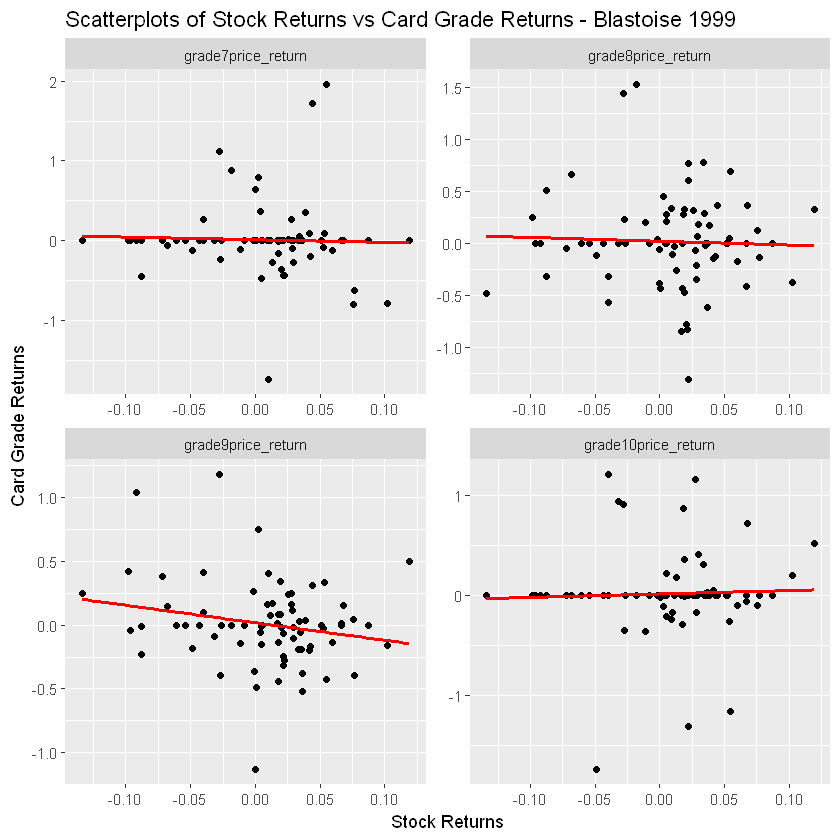

In [5]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestock_return"), measure.vars = grade_returns)

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestock_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Models

### OLS

In [6]:
#OLS
ols_models <- list()
for(grade_return in grade_returns) {
  ols_models[[grade_return]] <- lm(get(grade_return) ~ adjclosestock_return, data = df)
}

#print summary of each OLS model
for(grade_return in grade_returns) {
  print(paste("Summary of model for:", grade_return))
  print(summary(ols_models[[grade_return]]))
}


[1] "Summary of model for: grade7price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.74859 -0.08438 -0.01119  0.00468  1.96101 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.01301    0.05503   0.237    0.814
adjclosestock_return -0.33430    1.10804  -0.302    0.764

Residual standard error: 0.4702 on 73 degrees of freedom
Multiple R-squared:  0.001245,	Adjusted R-squared:  -0.01244 
F-statistic: 0.09103 on 1 and 73 DF,  p-value: 0.7637

[1] "Summary of model for: grade8price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32027 -0.16293 -0.02294  0.19319  1.49749 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.02450    0.05259   0.466    0.643
adjclosestock_return -0.36542    1.05890  -0.345    0.731

### Quantile regression

In [7]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = 0.1)  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  print(paste("Summary of quantile regression model for:", grade_return))
  print(summary(quantile_models[[grade_return]]))
}


[1] "Summary of quantile regression model for: grade7price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.37339     -0.49702 -0.27226
adjclosestock_return -2.79339     -3.65177  0.10825
[1] "Summary of quantile regression model for: grade8price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.43365     -0.70680 -0.39293
adjclosestock_return  0.32937     -2.25229  1.48041
[1] "Summary of quantile regression model for: grade9price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.33294     -0.45913 -0.26191
adjclosestock_return -1.18349

In [8]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step

#### Results for different quantiles of the grade prices x OLS estimates (red line) 

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

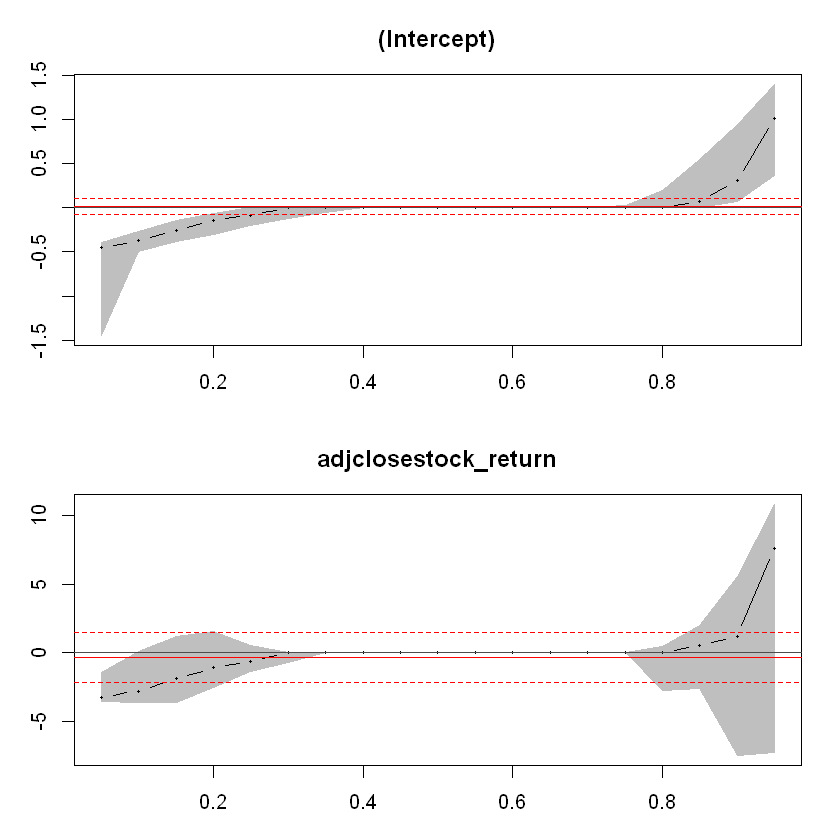

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

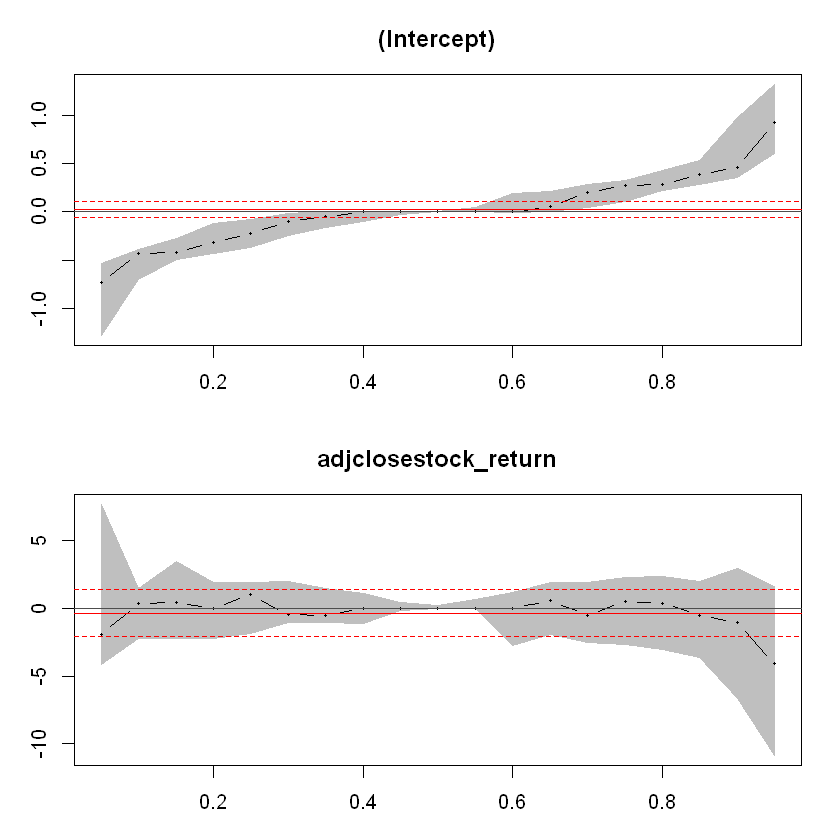

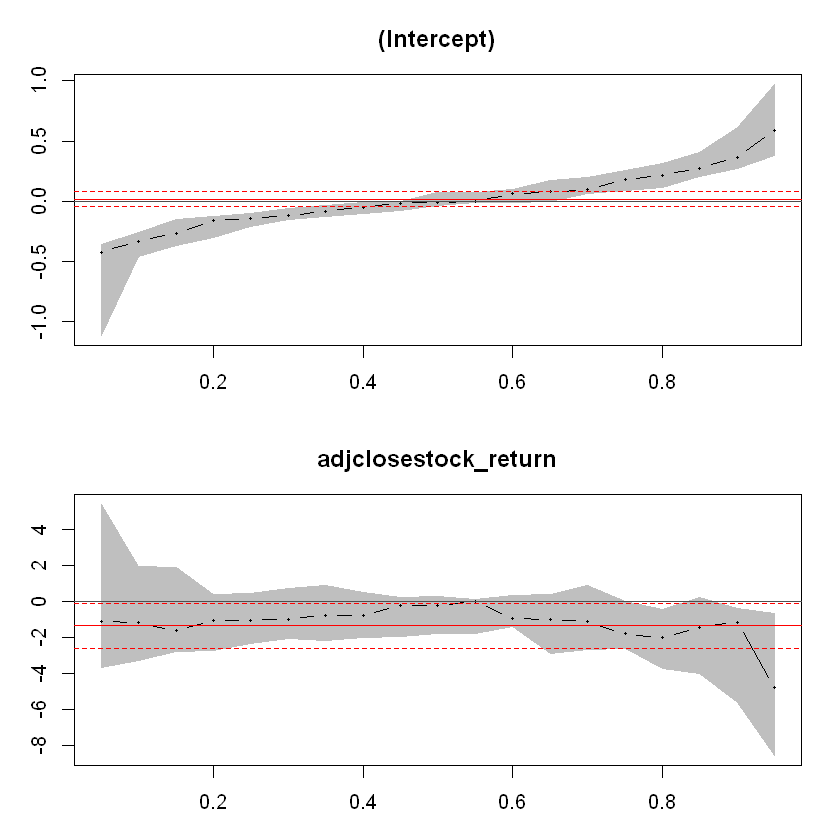

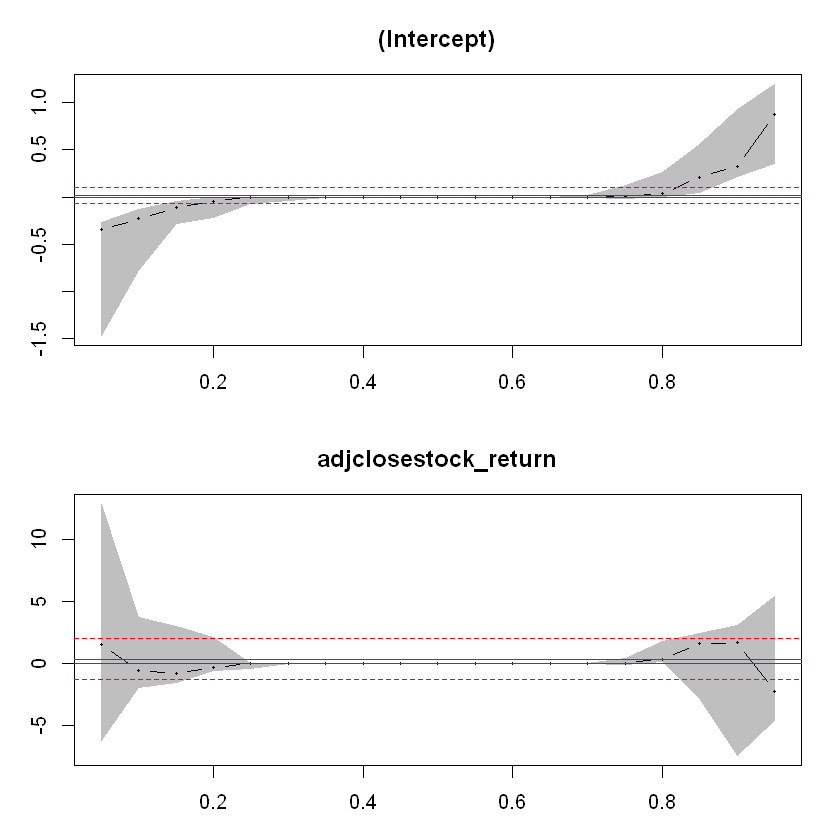

In [10]:

for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
  plot(summary(quantile_models[[grade_return]]))
}